<a href="https://colab.research.google.com/github/sappw1/Dissertation/blob/main/Notebooks/Notebooks-Working/Modeling/01a_Clustering_Methodology_GPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Tue May 13 16:36:23 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   34C    P0             47W /  400W |       0MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [2]:
from google.colab import drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cudf
import cupy as cp
import json, time, os
from datetime import datetime
from cuml.cluster import KMeans as cuKMeans
from cuml.metrics.cluster.silhouette_score import cython_silhouette_score
from sklearn.metrics import davies_bouldin_score
# APA Style
plt.style.use("default")  # You can upload apa.mplstyle if needed

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
# Mount your Drive
drive.mount('/content/drive')

# Set the path where your files are stored
input_dir = "/content/drive/MyDrive/NCU/Dissertation/Data/Processed/PCA_Arrays"

# Load each file
X_all_pca = cp.load(os.path.join(input_dir, "X_all_pca.npy"))
X_all_pca_2 = cp.load(os.path.join(input_dir, "X_all_pca_2.npy"))
X_all_pca_3 = cp.load(os.path.join(input_dir, "X_all_pca_3.npy"))
X_key_pca = cp.load(os.path.join(input_dir, "X_key_pca.npy"))
X_key_pca_2 = cp.load(os.path.join(input_dir, "X_key_pca_2.npy"))
X_key_pca_3 = cp.load(os.path.join(input_dir, "X_key_pca_3.npy"))

print("All PCA arrays loaded from Google Drive.")

# Convert to GPU cuDF format
def to_cudf(cp_array):
    return cudf.DataFrame(cp_array)

# Input dictionary
pca_inputs = {
    "Full (95%)": to_cudf(X_all_pca),
    "Full (2C)": to_cudf(X_all_pca_2),
    "Full (3C)": to_cudf(X_all_pca_3),
    "Key (95%)": to_cudf(X_key_pca),
    "Key (2C)": to_cudf(X_key_pca_2),
    "Key (3C)": to_cudf(X_key_pca_3),
}

Mounted at /content/drive
All PCA arrays loaded from Google Drive.


In [5]:
# Storage
kmeans_results = {}
checkpoint_path = "/content/drive/MyDrive/NCU/Dissertation/Data/Processed/kmeans_gpu_progress.json"  # Save to Drive if mounted

os.makedirs(os.path.dirname(checkpoint_path), exist_ok=True)

# Loop
for name, X in pca_inputs.items():
    print(f"\n [{datetime.now().strftime('%H:%M:%S')}] Starting GPU K-Means for: {name} | Shape: {X.shape}")
    start_time = time.time()

    distortions = []
    silhouette_scores = []
    K_range = range(2, 10)

    for k in K_range:
        t0 = time.time()
        km = cuKMeans(n_clusters=k, random_state=42, n_init="auto")
        km.fit(X)
        labels = km.predict(X)
        inertia = float(km.inertia_)
        sil = float(cython_silhouette_score(X, labels, metric='euclidean'))
        distortions.append(inertia)
        silhouette_scores.append(sil)
        print(f"     k={k} | Silhouette={sil:.4f} | Time: {time.time() - t0:.2f}s")

    optimal_k = K_range[np.argmax(silhouette_scores)]
    print(f" Optimal k: {optimal_k}")

    # Final model
    final_km = cuKMeans(n_clusters=optimal_k, random_state=42)
    final_labels = final_km.fit_predict(X)
    db_index = davies_bouldin_score(X.to_numpy(), final_labels.to_numpy())
    final_silhouette = float(cython_silhouette_score(X, final_labels, metric='euclidean'))

    print(f"Final Metrics | Silhouette={final_silhouette:.4f} | Time: {time.time() - start_time:.2f}s")

    # Store results
    kmeans_results[name] = {
        "optimal_k": int(optimal_k),
        "silhouette": final_silhouette,
        "db_index": db_index,
        "k_values": list(K_range),
        "silhouette_scores": silhouette_scores,
        "distortions": distortions,
    }

    # Save checkpoint
    with open(checkpoint_path, "w") as f:
        json.dump(kmeans_results, f, indent=4)

    print(f" Results saved to {checkpoint_path}")

print("\n All GPU KMeans runs complete.")



 [16:37:39] Starting GPU K-Means for: Full (95%) | Shape: (940481, 1)
     k=2 | Silhouette=0.8696 | Time: 184.95s
     k=3 | Silhouette=0.7866 | Time: 196.52s
     k=4 | Silhouette=0.7586 | Time: 199.42s
     k=5 | Silhouette=0.7009 | Time: 198.44s
     k=6 | Silhouette=0.6887 | Time: 197.07s
     k=7 | Silhouette=0.6522 | Time: 197.57s
     k=8 | Silhouette=0.6467 | Time: 182.45s
     k=9 | Silhouette=0.6399 | Time: 199.09s
 Optimal k: 2
Final Metrics | Silhouette=0.8696 | Time: 1751.48s
 Results saved to /content/drive/MyDrive/NCU/Dissertation/Data/Processed/kmeans_gpu_progress.json

 [17:06:50] Starting GPU K-Means for: Full (2C) | Shape: (940481, 2)
     k=2 | Silhouette=0.8572 | Time: 195.88s
     k=3 | Silhouette=0.7531 | Time: 197.47s
     k=4 | Silhouette=0.7140 | Time: 213.85s
     k=5 | Silhouette=0.6211 | Time: 197.08s
     k=6 | Silhouette=0.5997 | Time: 214.61s
     k=7 | Silhouette=0.5259 | Time: 215.45s
     k=8 | Silhouette=0.5133 | Time: 197.60s
     k=9 | Silhouette

In [1]:
import json

with open("Data\Processed\kmeans_gpu_progress.json") as f:
    kmeans_results = json.load(f)


<>:3: SyntaxWarning: invalid escape sequence '\P'
<>:3: SyntaxWarning: invalid escape sequence '\P'
C:\Users\sappw\AppData\Local\Temp\ipykernel_8904\4091018379.py:3: SyntaxWarning: invalid escape sequence '\P'
  with open("Data\Processed\kmeans_gpu_progress.json") as f:


In [ ]:
from cuml.cluster import KMeans as cuKMeans

# Example: re-run for x_all_pca_2
kmeans_2 = cuKMeans(n_clusters=2, random_state=42)
labels_2 = kmeans_2.fit_predict(x_all_pca_2)

kmeans_3 = cuKMeans(n_clusters=3, random_state=42)
labels_3 = kmeans_3.fit_predict(x_all_pca_2)


In [2]:
import pandas as pd

# Assuming you have the dictionary already loaded as `kmeans_results`
summary_data = []
for config, metrics in kmeans_results.items():
    summary_data.append({
        "Configuration": config,
        "Optimal_k": metrics["optimal_k"],
        "Silhouette": round(metrics["silhouette"], 4),
        "Davies-Bouldin": round(metrics["db_index"], 4)
    })

summary_df = pd.DataFrame(summary_data).sort_values("Silhouette", ascending=False)

# Display the table
from IPython.display import display, Markdown
display(summary_df)

# Export to LaTeX
latex_table = summary_df.to_latex(index=False, caption="K-Means Clustering Performance Summary", label="tab:kmeans_summary")
print(latex_table)


,Configuration,Optimal_k,Silhouette,Davies-Bouldin
0,Full (95%),2,0.8696,0.4809
1,Full (2C),2,0.8572,0.4904
2,Full (3C),2,0.8569,0.4983
3,Key (95%),2,0.7081,0.4080
4,Key (2C),2,0.7070,0.4089
5,Key (3C),2,0.7069,0.4090


\begin{table}
\caption{K-Means Clustering Performance Summary}
\label{tab:kmeans_summary}
\begin{tabular}{lrrr}
\toprule
Configuration & Optimal_k & Silhouette & Davies-Bouldin \\
\midrule
Full (95%) & 2 & 0.869600 & 0.480900 \\
Full (2C) & 2 & 0.857200 & 0.490400 \\
Full (3C) & 2 & 0.856900 & 0.498300 \\
Key (95%) & 2 & 0.708100 & 0.408000 \\
Key (2C) & 2 & 0.707000 & 0.408900 \\
Key (3C) & 2 & 0.706900 & 0.409000 \\
\bottomrule
\end{tabular}
\end{table}



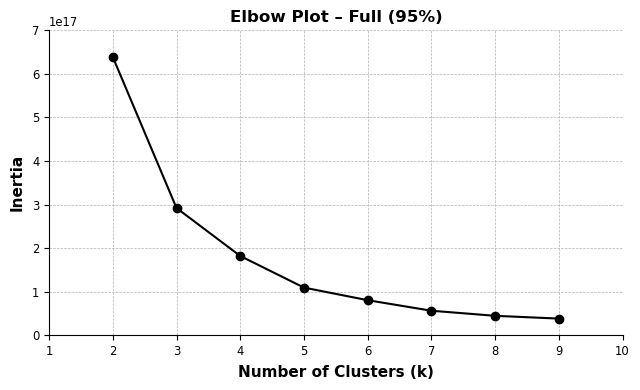

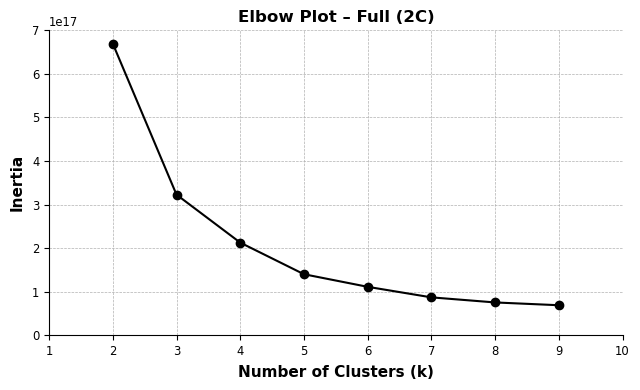

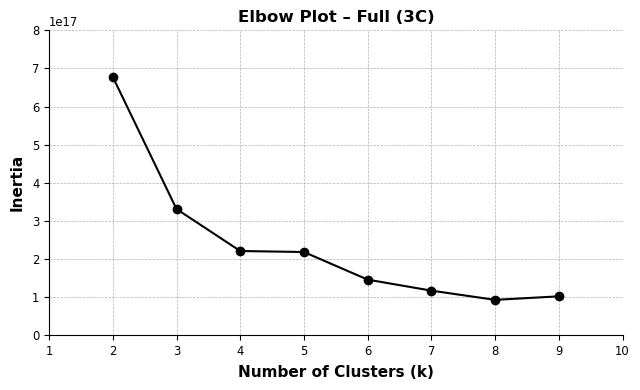

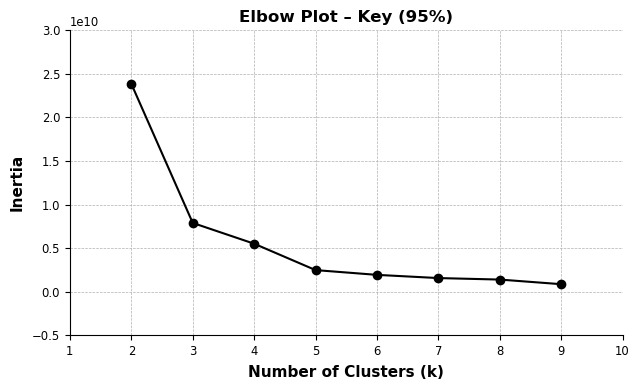

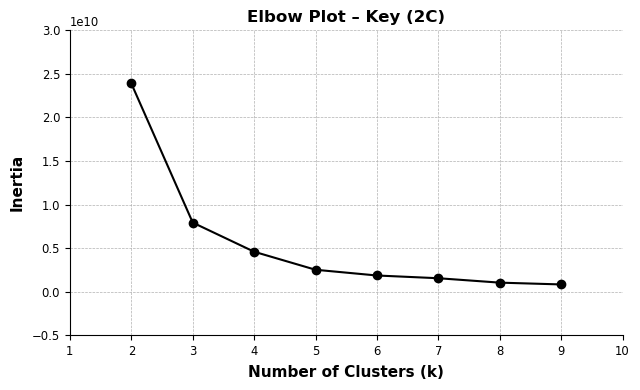

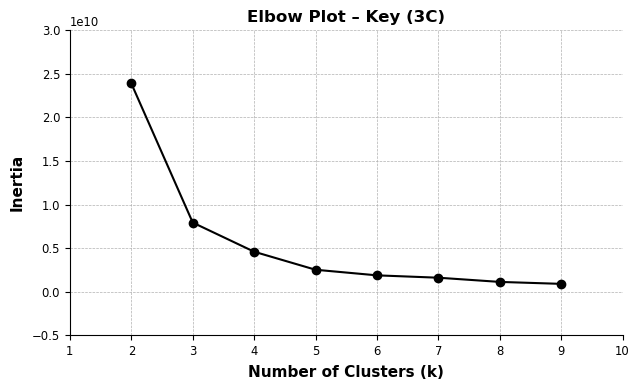

In [4]:
import matplotlib.pyplot as plt

plt.style.use("apa.mplstyle")

# Generate elbow plots from kmeans_results
for config, metrics in kmeans_results.items():
    k_vals = metrics["k_values"]
    inertia_vals = metrics["distortions"]

    fig, ax = plt.subplots(figsize=(6.5, 4))  # APA-preferred size
    ax.plot(k_vals, inertia_vals, marker='o', linewidth=1.5)

    ax.set_title(f'Elbow Plot – {config}', fontsize=12)
    ax.set_xlabel('Number of Clusters (k)', fontsize=11)
    ax.set_ylabel('Inertia', fontsize=11)

    ax.grid(True, linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()


Although silhouette analysis identified k=2 as optimal due to maximum cluster cohesion and separation, the elbow method suggests 
k=3 may better capture additional structural variance in the data. This indicates a potential tradeoff between cluster purity and complexity, warranting further investigation through qualitative cluster interpretation and downstream classification performance

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import silhouette_samples, silhouette_score
import numpy as np
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D  # Needed for 3D scatter plots

#  Apply APA style
plt.style.use("apa.mplstyle")

#  Assumes these are already defined:
# pca_2d_full, pca_3d_full: np.ndarray of PCA-transformed features
input_dir = "/content/drive/MyDrive/NCU/Dissertation/Data/Processed/PCA_Arrays"

# Load each file
X_all_pca = cp.load(os.path.join(input_dir, "X_all_pca.npy"))
X_all_pca_2 = cp.load(os.path.join(input_dir, "X_all_pca_2.npy"))
X_all_pca_3 = cp.load(os.path.join(input_dir, "X_all_pca_3.npy"))
X_key_pca = cp.load(os.path.join(input_dir, "X_key_pca.npy"))
X_key_pca_2 = cp.load(os.path.join(input_dir, "X_key_pca_2.npy"))
X_key_pca_3 = cp.load(os.path.join(input_dir, "X_key_pca_3.npy"))

# y_true: true fraud labels (binary)
# kmeans_labels_2, kmeans_labels_3: cluster labels for k=2 and k=3

# Convert to DataFrame for ease of use
df_vis = pd.DataFrame({
    'PC1': pca_2d_full[:, 0],
    'PC2': pca_2d_full[:, 1],
    'PC3': pca_3d_full[:, 2],
    'FraudLabel': y_true,
    'KMeans_2': kmeans_labels_2,
    'KMeans_3': kmeans_labels_3
})

#  1. PCA 2D – True Labels
sns.set_context("notebook")
fig, ax = plt.subplots(figsize=(6.5, 4))
sns.scatterplot(data=df_vis, x="PC1", y="PC2", hue="FraudLabel", palette="Set1", ax=ax)
ax.set_title("PCA (2D) – Colored by True Fraud Labels")
plt.tight_layout()
plt.show()

#  2. PCA 2D – KMeans k=2
fig, ax = plt.subplots(figsize=(6.5, 4))
sns.scatterplot(data=df_vis, x="PC1", y="PC2", hue="KMeans_2", palette="Set2", ax=ax)
ax.set_title("PCA (2D) – K-Means Clustering (k=2)")
plt.tight_layout()
plt.show()

#  3. PCA 2D – KMeans k=3
fig, ax = plt.subplots(figsize=(6.5, 4))
sns.scatterplot(data=df_vis, x="PC1", y="PC2", hue="KMeans_3", palette="Set3", ax=ax)
ax.set_title("PCA (2D) – K-Means Clustering (k=3)")
plt.tight_layout()
plt.show()

#  4. PCA 3D – True Fraud Labels
fig = plt.figure(figsize=(7, 5))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(df_vis["PC1"], df_vis["PC2"], df_vis["PC3"],
                     c=df_vis["FraudLabel"], cmap="coolwarm", s=30)
ax.set_title("PCA (3D) – Colored by True Fraud Labels")
ax.set_xlabel("PC1"); ax.set_ylabel("PC2"); ax.set_zlabel("PC3")
plt.tight_layout()
plt.show()

#  5. Elbow Plot – Use existing kmeans_results
for config, metrics in kmeans_results.items():
    fig, ax = plt.subplots(figsize=(6.5, 4))
    ax.plot(metrics["k_values"], metrics["distortions"], marker='o')
    ax.set_title(f'Elbow Plot – {config}')
    ax.set_xlabel('Number of Clusters (k)')
    ax.set_ylabel('Inertia')
    ax.grid(True, linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()

#  6. Silhouette Score Line Plot
for config, metrics in kmeans_results.items():
    fig, ax = plt.subplots(figsize=(6.5, 4))
    ax.plot(metrics["k_values"], metrics["silhouette_scores"], marker='o')
    ax.set_title(f'Silhouette Score vs. k – {config}')
    ax.set_xlabel('Number of Clusters (k)')
    ax.set_ylabel('Silhouette Score')
    ax.grid(True, linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()

#  7. Silhouette Analysis Plot (k=2 and k=3)
def silhouette_analysis(X, labels, k):
    silhouette_vals = silhouette_samples(X, labels)
    y_lower = 10
    fig, ax = plt.subplots(figsize=(6.5, 4))

    for i in range(k):
        ith_cluster_silhouette_vals = silhouette_vals[labels == i]
        ith_cluster_silhouette_vals.sort()
        size_cluster_i = ith_cluster_silhouette_vals.shape[0]
        y_upper = y_lower + size_cluster_i
        color = plt.cm.tab10(i / k)
        ax.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_vals,
                         facecolor=color, edgecolor=color, alpha=0.7)
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10

    ax.set_title(f"Silhouette Plot for k={k}")
    ax.set_xlabel("Silhouette Coefficient")
    ax.set_ylabel("Cluster Label")
    ax.axvline(x=silhouette_score(X, labels), color="red", linestyle="--")
    ax.set_yticks([])  # Clear y-axis
    plt.tight_layout()
    plt.show()

# Run for both k=2 and k=3
silhouette_analysis(pca_2d_full, kmeans_labels_2, 2)
silhouette_analysis(pca_2d_full, kmeans_labels_3, 3)

#  8. Davies-Bouldin Index Plot
fig, ax = plt.subplots(figsize=(6.5, 4))
configs = list(kmeans_results.keys())
db_values = [kmeans_results[c]["db_index"] for c in configs]
ax.barh(configs, db_values, color="gray")
ax.set_title("Davies-Bouldin Index by Configuration")
ax.set_xlabel("DB Index")
plt.tight_layout()
plt.show()
